In [116]:
import pandas as pd

In [117]:
# read data
df_rain = pd.read_csv("./data/chennai-monthly-rains.csv")
df_flood = pd.read_csv("./data/chennai-monthly-manual-flood.csv")

In [118]:
# clean data
df_flood = df_flood[(df_flood.year <= 2021)]

In [119]:
# merge datasets
df = pd.merge(df_rain,df_flood, left_on='Year', right_on='year')

In [120]:
# concat columns
df = pd.concat([df, df[["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]].T.stack().reset_index(name='months_rain')['months_rain']], axis=1)
df = pd.concat([df, df[["jan","feb","mar","apr","may","jun","jul","aug","sep","oct","nov","dec"]].T.stack().reset_index(name='months_flood')['months_flood']], axis=1)

In [121]:
# drop unnecessary columns
df.drop(inplace=True, columns=["Year","Total","Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
df.drop(inplace=True, columns=["year","jan","feb","mar","apr","may","jun","jul","aug","sep","oct","nov","dec"])

In [122]:
# stats
print(df[['months_rain','months_flood']].describe())

       months_rain  months_flood
count  1452.000000   1452.000000
mean    102.658846      0.005510
std     146.448407      0.074048
min       0.000000      0.000000
25%       3.891515      0.000000
50%      50.316214      0.000000
75%     135.978452      0.000000
max    1061.642222      1.000000


check shape

In [123]:
print("Original shape:", df.shape)

Original shape: (1452, 2)


In [124]:
import matplotlib.pyplot as plt

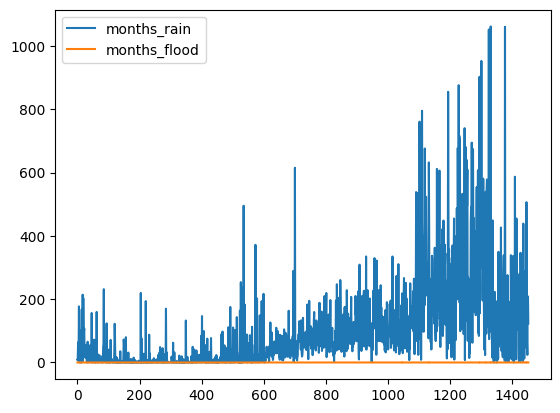

In [125]:
# visualise data
df.plot()
plt.show()

In [126]:
import numpy as np

In [127]:
# check data balance
# Adapted from: “Classification on imbalanced data | TensorFlow Core,” TensorFlow. https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

neg, pos = np.bincount(df['months_flood'])
t = neg + pos
print(f"Total: %d; positive: %d (%.2f%% of total)" % (t,pos,(100*pos/t)))

Total: 1452; positive: 8 (0.55% of total)


In [128]:
# data-target split
X = df[df.columns[:-1]]
y = df[df.columns[-1:]]

In [129]:
# check shape after sampling target data
print("X:",X.shape)
print("y:",y.shape)

X: (1452, 1)
y: (1452, 1)


In [130]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [131]:
# z-score
std_scaler = StandardScaler()
X_zerod = std_scaler.fit_transform(X)
X = pd.DataFrame(X_zerod, columns=list(X.columns))

In [132]:
# normalise data
minmax_scaler = MinMaxScaler()
X_scaled = minmax_scaler.fit_transform(X) #scaler.fit_transform(X_train.drop(columns="Year"))
X = pd.DataFrame(X_scaled, columns=list(X.columns))

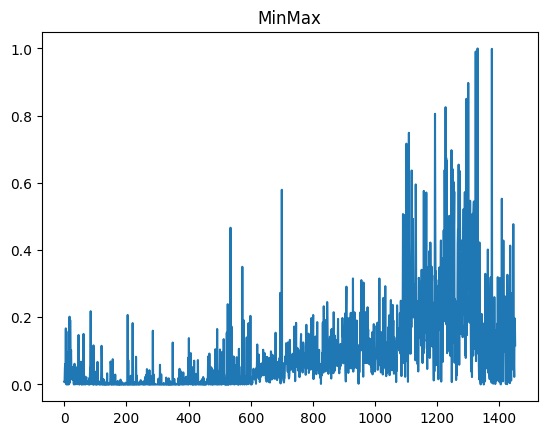

In [133]:
plt.plot(X)
plt.title("MinMax")
plt.show()

In [134]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [135]:
# over- (SMOTE) and under-sampling
oversample = SMOTE(sampling_strategy=0.1, k_neighbors=2)
understample = RandomUnderSampler()

In [136]:
X, y = oversample.fit_resample(X, y); print("Y",y)
X, y = understample.fit_resample(X, y)

Y       months_flood
0              0.0
1              0.0
2              0.0
3              0.0
4              0.0
...            ...
1583           1.0
1584           1.0
1585           1.0
1586           1.0
1587           1.0

[1588 rows x 1 columns]


In [137]:
# lag and forecast
# Adapted from: J. Brownlee, “How to Convert a Time Series to a Supervised Learning Problem in Python,” Machine Learning Mastery, May 07, 2017. https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
LAG = 1
FORE = 1
cols, names = list(), list()
for i in range(LAG, 0, -1):
    cols.append(X.shift(i))
    names += [(f'var%d(t-%d)' % (j+1, i)) for j in range(X.shape[1])]
for i in range(0, FORE):
    cols.append(X.shift(-1))
if i == 0:
    names += [(f'var%d(t)' % (j+1)) for j in range(X.shape[1])]
else:
    names += [(f'var%d(t+%d)' % (j+1, i)) for j in range(X.shape[1])]
X = pd.concat(cols,axis=1)
X.columns = names
X.dropna(inplace=True)

In [138]:
# reshape data
# Adapted from: S. S. Bhakta, “Multivariate Time Series Forecasting with LSTMs in Keras,” GeeksforGeeks, Feb. 17, 2024. https://www.geeksforgeeks.org/multivariate-time-series-forecasting-with-lstms-in-keras/ (accessed May 02, 2024).
seq = 20
dfX = []
dfY = []
for i in range(0,len(X) - seq):
    data = [[X[col].iloc[i+j] for col in X.columns] for j in range(0,seq)]
    dfX.append(data)
    dfY.append(y[['months_flood']].iloc[i + seq].values)
X, y = np.array(dfX), np.array(dfY)

In [139]:
# check shape after reshaping
print("X:",X.shape)
print("y:",y.shape)

X: (266, 20, 2)
y: (266, 1)


In [140]:
from sklearn.model_selection import train_test_split

In [141]:
# data splitting
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [142]:
# train-validation split
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.1, random_state=42)

In [143]:
# check shape after splitting
print("X_train:",X_train.shape,"X_test:",X_test.shape)
print("y_train:",y_train.shape,"y_test:",y_test.shape)
print("X_val:",X_val.shape,"y_val:",y_val.shape)

X_train: (190, 20, 2) X_test: (54, 20, 2)
y_train: (190, 1) y_test: (54, 1)
X_val: (22, 20, 2) y_val: (22, 1)


In [144]:
import tensorflow as tf
import keras_tuner as kt

In [145]:
def build_model(hp):

    # hyper parameter tuning
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    hp_units_2 = hp.Int('units', min_value=32, max_value=512, step=32)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # force GPU
    #with tf.device('/GPU:0'):

    # define metrics
    METRICS = [
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.BinaryCrossentropy(name='log loss'),
        tf.keras.metrics.TruePositives(name='TP'),
        tf.keras.metrics.TrueNegatives(name='TN'),
        tf.keras.metrics.FalsePositives(name='FP'),
        tf.keras.metrics.FalseNegatives(name='FN'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='prc', curve='PR')
    ]

    # LSTM
    model = tf.keras.Sequential()
    model.add(tf.keras.Input((X_train.shape[1], X_train.shape[2])))
    model.add(tf.keras.layers.LSTM(units=hp_units, return_sequences=True))
    model.add(tf.keras.layers.LSTM(units=hp_units_2))
    model.add(tf.keras.layers.Dropout(0.2)) # drop data to control overfitting
    model.add(tf.keras.layers.Dense(units=1, activation='sigmoid', bias_initializer=tf.keras.initializers.Constant(np.log([pos/neg]))))
    model.compile(loss='BinaryCrossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), metrics=METRICS)
    model.summary()

    #print(X_train.shape[1])
    return model

In [146]:
# enable early stopping
cb = tf.keras.callbacks.EarlyStopping(monitor='val_prc', verbose=1, patience=3, mode='max', restore_best_weights=True)

In [147]:
# hyperparameter search
tuner = kt.Hyperband(build_model, objective=kt.Objective('prc', direction='max'), max_epochs=10, factor=3)
tuner.search(X_train, y_train, epochs=50, callbacks=[cb])
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

Reloading Tuner from ./untitled_project/tuner0.json


In [148]:
print(best_hp.get('units'), best_hp.get('learning_rate'))

320 0.001


In [149]:
# use best model
model = tuner.hypermodel.build(best_hp)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 20, 320)        │       413,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 320)            │       820,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           321 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,234,241 (4.71 MB)

 Trainable params: 1,234,241 (4.71 MB)

 Non-trainable params: 0 (0.00 B)

create class weights<br>
Adapted from: “Classification on imbalanced data: Tensorflow Core,” TensorFlow, https://www.tensorflow.org/tutorials/structured_data/imbalanced_data (accessed May 2, 2024). <br>
eight_neg = (1 / neg) * (t / 2.0)<br>
eight_pos = (1 / pos) * (t / 2.0)

eights = {0: weight_neg, 1: weight_pos}; print("Weights:", weights)

In [150]:
# training
history = model.fit(X_train, y_train, epochs=20, batch_size=1, validation_data=(X_val, y_val), verbose=1, callbacks=[cb]) #, class_weight=weights)

Epoch 1/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - FN: 9.8639 - FP: 3.3717 - TN: 43.3456 - TP: 39.4136 - accuracy: 0.8314 - log loss: 0.5985 - loss: 0.5985 - prc: 0.8833 - precision: 0.8668 - recall: 0.7170 - val_FN: 0.0000e+00 - val_FP: 1.0000 - val_TN: 11.0000 - val_TP: 10.0000 - val_accuracy: 0.9545 - val_log loss: 0.0474 - val_loss: 0.0474 - val_prc: 1.0000 - val_precision: 0.9091 - val_recall: 1.0000
Epoch 2/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - FN: 9.9005 - FP: 3.8272 - TN: 36.2042 - TP: 46.0628 - accuracy: 0.8791 - log loss: 0.4466 - loss: 0.4466 - prc: 0.9587 - precision: 0.9294 - recall: 0.8476 - val_FN: 0.0000e+00 - val_FP: 0.0000e+00 - val_TN: 12.0000 - val_TP: 10.0000 - val_accuracy: 1.0000 - val_log loss: 0.0163 - val_loss: 0.0163 - val_prc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - FN: 4.5445 - FP: 8.7382 - TN: 34.2147 - TP: 48.4974 - accuracy: 0.8884 - log loss: 0.4122 - loss: 0.4122 - prc: 0.865

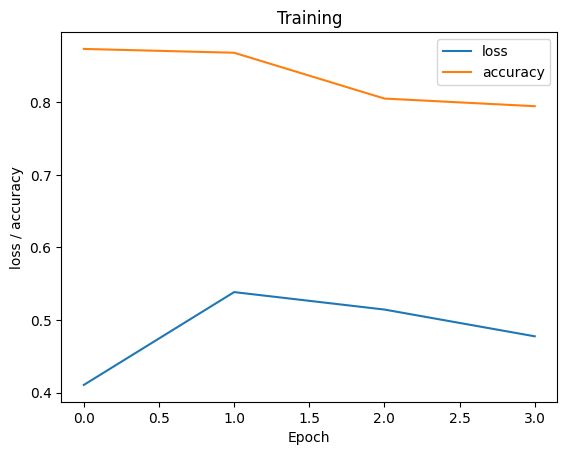

In [151]:
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.ylabel("loss / accuracy")
plt.xlabel("Epoch")
plt.legend(['loss','accuracy'])
plt.title("Training")
plt.show()

In [152]:
# make prediction
y_pred = model.predict(X_test)
y_pred = np.where(y_pred > 0.9, 1, 0) # magic number = 0.026; with weights = ~0.5325
y_pred = pd.DataFrame(y_pred, columns=list(df[df.columns[-1:]]))

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7fdef8e69630> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


In [153]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, classification_report, confusion_matrix

In [154]:
#evaluate prediction
model.evaluate(X_test, y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - FN: 1.3333 - FP: 0.0000e+00 - TN: 23.0000 - TP: 22.3333 - accuracy: 0.9753 - log loss: 0.1297 - loss: 0.1297 - prc: 0.9890 - precision: 1.0000 - recall: 0.9506     


[0.19310137629508972,
 0.9629629850387573,
 0.19310137629508972,
 25.0,
 27.0,
 0.0,
 2.0,
 1.0,
 0.9259259104728699,
 0.9834755063056946]

In [155]:
print("Actual:")
print(pd.DataFrame(y_test, columns=list(df[df.columns[-1:]])))
print("Predictions:")
print(y_pred)
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Actual:
    months_flood
0            1.0
1            0.0
2            1.0
3            1.0
4            0.0
5            1.0
6            1.0
7            0.0
8            0.0
9            0.0
10           0.0
11           0.0
12           1.0
13           1.0
14           1.0
15           0.0
16           0.0
17           0.0
18           0.0
19           0.0
20           0.0
21           1.0
22           1.0
23           1.0
24           1.0
25           1.0
26           0.0
27           0.0
28           1.0
29           1.0
30           1.0
31           1.0
32           0.0
33           0.0
34           1.0
35           0.0
36           1.0
37           0.0
38           0.0
39           0.0
40           0.0
41           1.0
42           1.0
43           1.0
44           0.0
45           1.0
46           1.0
47           1.0
48           0.0
49           0.0
50           1.0
51           1.0
52           0.0
53           0.0
Predictions:
    months_flood
0              1
1         

In [156]:
import seaborn as sns

Text(50.722222222222214, 0.5, 'Predicted')

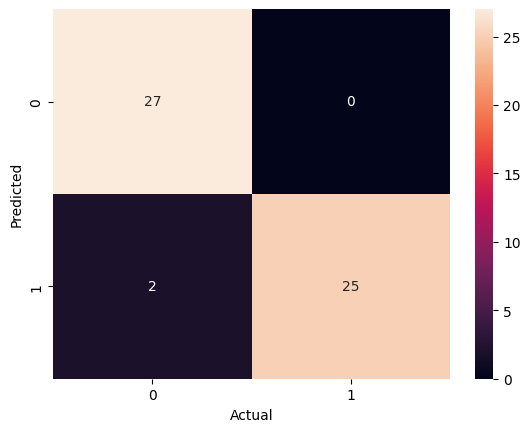

In [158]:
# confusion matrix
conmat = confusion_matrix(y_test, y_pred)
sns.heatmap(conmat, annot=True)
plt.xlabel("Actual")
plt.ylabel("Predicted")